In [1]:
from pathlib import Path
import pickle

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = "retina"

In [3]:
methods = {
    'sgd-rb-1': ('ogd', "olive", "dashdot"),
    # 'sgd-rb-2': ('r-sgd-2', plt.cm.Greens(0.3), "dashdot"),
    # 'sgd-rb-5': ('r-sgd-5', plt.cm.Greens(0.45), "dashdot"),
    'sgd-rb-10': ('r-sgd-10', plt.cm.Greens(0.9), "dashdot"),
    # 'sgd-rb-20': ('r-sgd-20', plt.cm.Greens(0.75), "dashdot"),
    # 'sgd-rb-50': ('r-sgd-50', plt.cm.Greens(0.9), "dashdot"),
    
    'adam-rb-1': ('r-adam-1', plt.cm.Reds(0.5), "--"),
    # 'adam-rb-2': ('r-adam-2', plt.cm.Reds(0.3), "--"),
    # 'adam-rb-5': ('r-adam-5', plt.cm.Reds(0.45), "--"),
    'adam-rb-10': ('r-adam-10', plt.cm.Reds(0.9), "--"),
    # 'adam-rb-20': ('r-adam-20', plt.cm.Reds(0.75), "--"),
    # 'adam-rb-50': ('r-adam-50', plt.cm.Reds(0.9), "--"),
    
    'fdekf': ('fdekf', 'black', "dotted"),
    'vdekf': ('vdekf', 'dimgray', "dotted"),
    
    'lofi-1': ('lofi-01', plt.cm.Blues(0.5), "-"),
    # 'lofi-2': ('lofi-02', plt.cm.Blues(0.3), "-"),
    # 'lofi-5': ('lofi-05', plt.cm.Blues(0.45), "-"),
    'lofi-10': ('lofi-10', plt.cm.Blues(0.9), "-"),
    # 'lofi-20': ('lofi-20', plt.cm.Blues(0.75), "-"),
    # 'lofi-50': ('lofi-50', plt.cm.Blues(0.9), "-"),
}

n_iter = 100

# Figure 2(a), Figure 19

## 1. 2,000 training data

In [ ]:
# Set environmental variables
%env REBAYES_OUTPUT=./iid-2000/f-mnist/mlp/nll
%env REBAYES_CONFIG=../configs/

# Run the script
# # To tune the hyperparameters:
# %run ../../run_regression_experiments.py \
#     --ranks 1 10 --dataset f-mnist --verbose 2 --model mlp --tune --ntrain 2000
%run ../../run_regression_experiments.py \
    --ranks 1 10 --dataset f-mnist --model mlp --n_iter 100 --ntrain 2000

In [4]:
path_fmnist_mlp = Path(Path.cwd(), "iid-2000", "f-mnist", "mlp", "nll")

agents_fmnist_mlp = (
    *[f"sgd-rb-{rank}" for rank in [1, 10,]],
    *[f"adam-rb-{rank}" for rank in [10,]],
    "fdekf", "vdekf",
    *[f"lofi-{rank}" for rank in [1, 10,]],
)

results_rmse_fmnist_mlp, results_nll_fmnist_mlp = {}, {}

for method in agents_fmnist_mlp:
    with open(Path(path_fmnist_mlp, f'{method}.pkl'), "rb") as f:
        curr_result = pickle.load(f)
    
    results_rmse_fmnist_mlp[method] = {
        "mean": jnp.mean(curr_result["rmse"], axis=0),
        "std": jnp.std(curr_result["rmse"], axis=0),
    }
    results_nll_fmnist_mlp[method] = {
        "mean": jnp.mean(curr_result["nll"], axis=0),
        "std": jnp.std(curr_result["nll"], axis=0),
    }

In [13]:
kernel_size = 15
kernel = jnp.ones((kernel_size,)) / kernel_size
convolve = lambda x: jnp.convolve(x, kernel, mode='same')

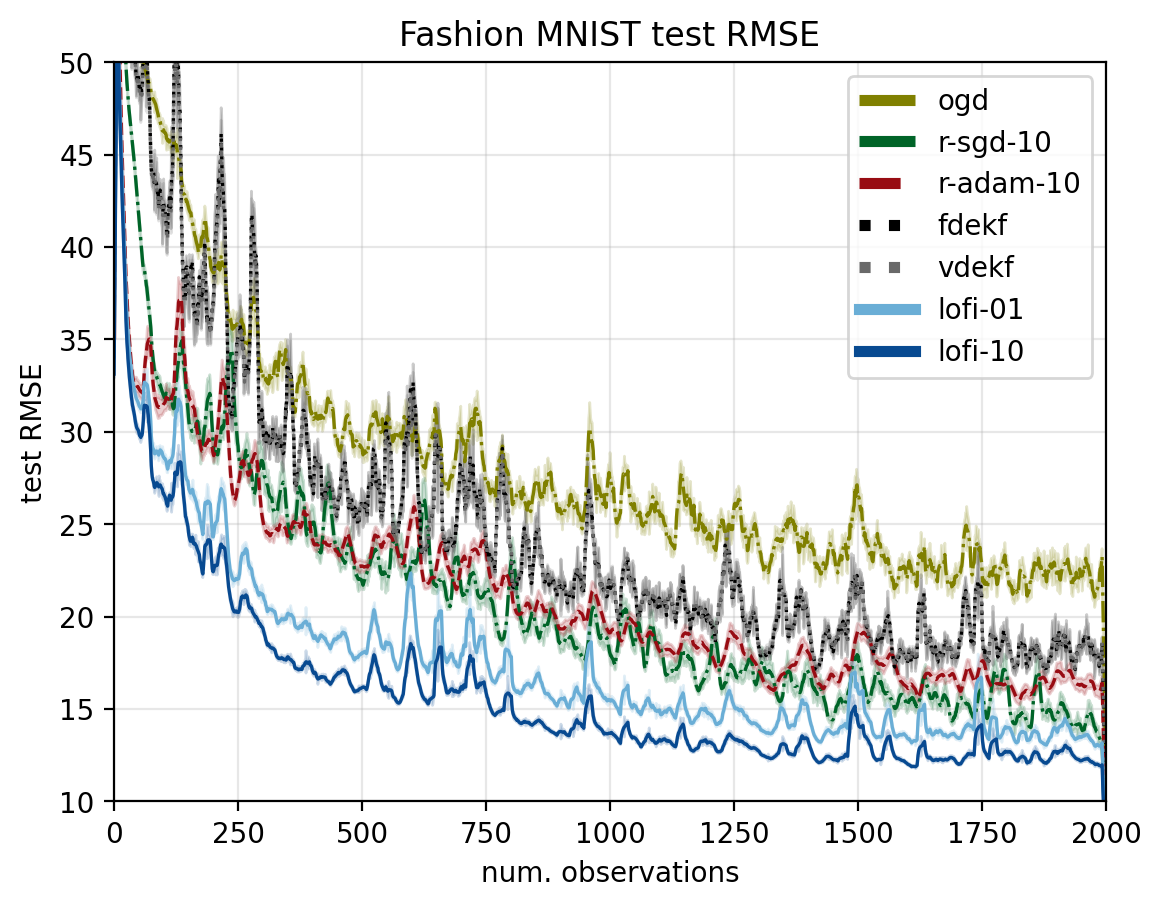

In [14]:
# RMSE
fig, ax = plt.subplots()
for key, val in results_rmse_fmnist_mlp.items():
    mean, std = convolve(val['mean']), val['std']
    label, color, ls = methods[key]
    ax.plot(mean, label=label, c=color, linewidth=1.2, linestyle=ls)
    ax.fill_between(
        jnp.arange(mean.shape[0]),
        mean - std / jnp.sqrt(n_iter),
        mean + std / jnp.sqrt(n_iter),
        alpha=0.2,
        color=color
    )
ax.set_xlabel('num. observations')
ax.set_ylabel('test RMSE')
ax.set_xlim(0, 2_000)
ax.set_ylim(10, 50)
ax.grid(alpha=0.3)
ax.set_title('Fashion MNIST test RMSE')
leg = ax.legend()
# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(4.0)

fig.savefig(Path(path_fmnist_mlp, 'fmnist-mlp-reg-test-rmse.pdf'), bbox_inches='tight')

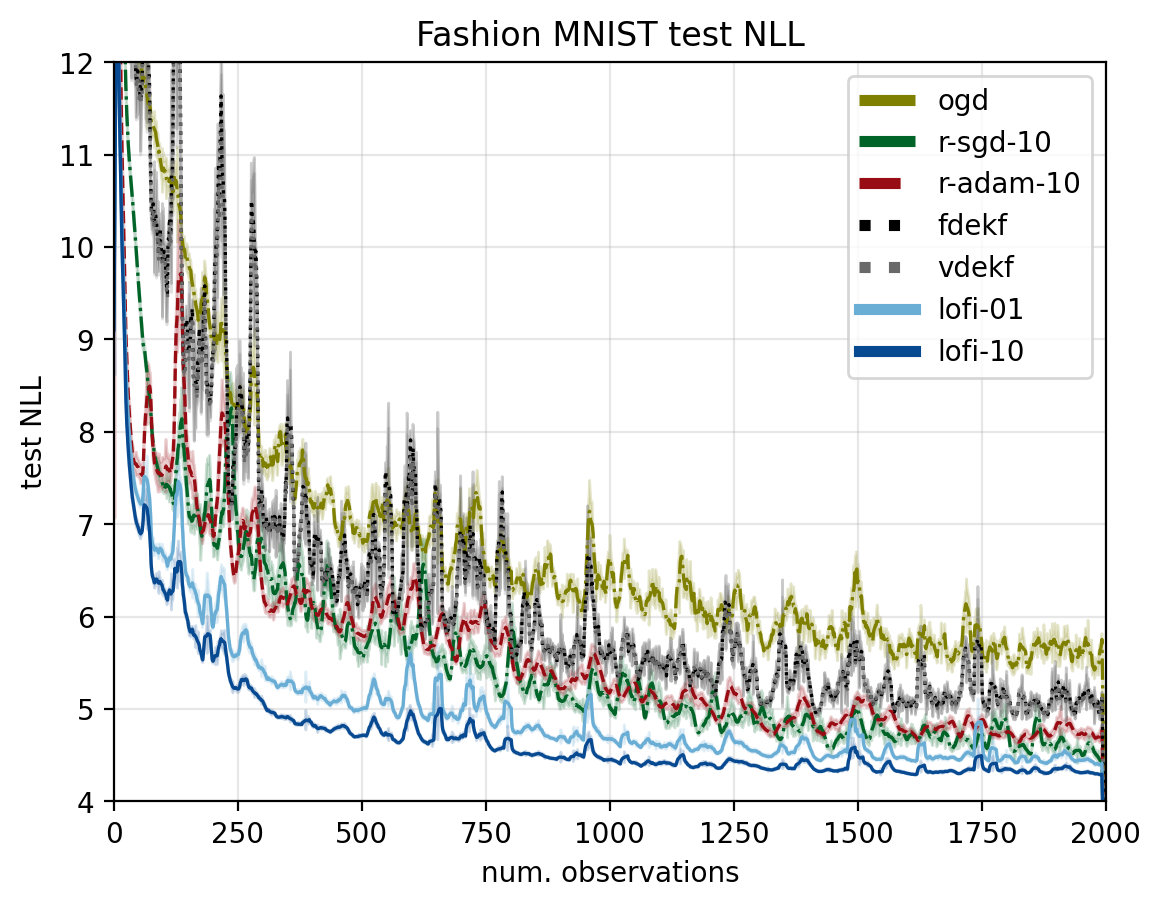

In [18]:
# NLL
fig, ax = plt.subplots()
for key, val in results_nll_fmnist_mlp.items():
    mean, std = convolve(val['mean']), val['std']
    label, color, ls = methods[key]
    ax.plot(mean, label=label, c=color, linewidth=1.2, linestyle=ls)
    ax.fill_between(
        jnp.arange(mean.shape[0]),
        mean - std / jnp.sqrt(n_iter),
        mean + std / jnp.sqrt(n_iter),
        alpha=0.2,
        color=color
    )
ax.set_xlabel('num. observations')
ax.set_ylabel('test NLL')
ax.set_xlim(0, 2_000)
ax.set_ylim(4.0, 12)
ax.grid(alpha=0.3)
ax.set_title('Fashion MNIST test NLL')
leg = ax.legend()
# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(4.0)

fig.savefig(Path(path_fmnist_mlp, 'fmnist-mlp-reg-test-nll.pdf'), bbox_inches='tight')

# NLPD

In [ ]:
# Set environmental variables
%env REBAYES_OUTPUT=./iid-1000/f-mnist/mlp
%env REBAYES_CONFIG=../configs/tmp/

# Run the script
# # To tune the hyperparameters:
# %run ../../run_regression_experiments.py \
#     --ranks 1 10 --dataset f-mnist --verbose 1 --model mlp --tune --ntrain 1000
%run ../../run_regression_experiments.py \
    --ranks 1 --dataset f-mnist --model mlp --n_iter 100 --ntrain 1000 --agents fdekf \
        --tune --nll_method nlpd-mc --n_explore 2 --n_exploit 2